In [1]:
# %load_ext autoreload
# %autoreload 2

# import datacube
# from dea_tools.dask import create_local_dask_cluster

# # Connect to datacube
# dc = datacube.Datacube()

# # Create local dask cluster to improve data load time
# client = create_local_dask_cluster(return_client=True)

In [ ]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4)

In [81]:
# dss = dc.find_datasets(product='s2a_ard_granule', id='e3e5d705-9f37-5016-9c9f-4df89c7e80d1')

ds = dc.load(product=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],   #['ga_s2am_ard_3', 'ga_s2bm_ard_3'], 
#              time='2022-10-07',
             time=('2021-01', '2021-12'),
             geopolygon=geom,
             measurements=['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir_1',
                           'solar_zenith', 'solar_azimuth', 
                           'satellite_azimuth', 'satellite_view', 
                           'relative_azimuth'], 
             output_crs='EPSG:3577', 
             group_by='solar_day',
             dask_chunks={},
             resolution=(-10, 10))

ds = ds.where(ds.nbart_red > 0).compute()


In [82]:
import numpy as np
import matplotlib.pyplot as plt


def glint_angle(solar_azimuth, solar_zenith, view_azimuth, view_zenith):
    """
    Calculates glint angles for each pixel in a satellite
    image based on the relationship between the solar and
    sensor zenith and azimuth viewing angles at the moment
    the image was acquired.

    Glint angle is considered a predictor of sunglint over
    water; small glint angles (e.g. < 20 degrees) are associated
    with a high probability of sunglint due to the viewing
    angle of the sensor being aligned with the specular
    reflectance of the sun from the water's surface.

    Based on code from https://towardsdatascience.com/how-to-implement-
    sunglint-detection-for-sentinel-2-images-in-python-using-metadata-
    info-155e683d50
    """

    # Convert angle arrays to radians
    solar_zenith_rad = np.deg2rad(solar_zenith)
    solar_azimuth_rad = np.deg2rad(solar_azimuth)
    view_zenith_rad = np.deg2rad(view_zenith)
    view_azimuth_rad = np.deg2rad(view_azimuth)

    # Calculate sunglint angle
    phi = solar_azimuth_rad - view_azimuth_rad
    glint_angle = np.cos(view_zenith_rad) * np.cos(solar_zenith_rad) - np.sin(
        view_zenith_rad
    ) * np.sin(solar_zenith_rad) * np.cos(phi)

    # Convert to degrees
    glint_array = np.degrees(np.arccos(glint_angle))

    return glint_array


glint_array = glint_angle(
    solar_azimuth=ds.solar_azimuth,
    solar_zenith=ds.solar_zenith,
    view_azimuth=ds.satellite_azimuth,
    view_zenith=ds.satellite_view,
)

# glint_array.plot(cmap="magma_r", col='time', col_wrap=5)

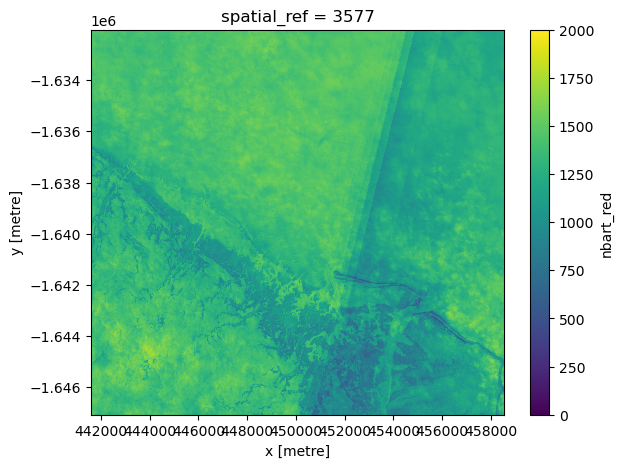

In [83]:
ds['nbart_red'].std('time').plot.imshow(vmin=0, vmax=2000, size=5)

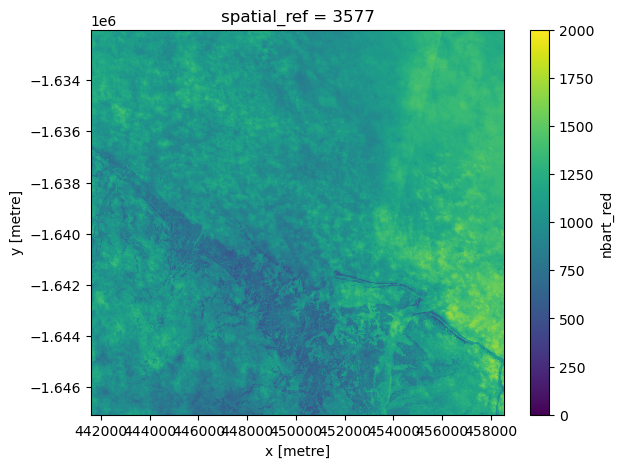

In [84]:
ds['nbart_red'].where(glint_array > 30).std('time').plot.imshow(vmin=0, vmax=2000, size=5)

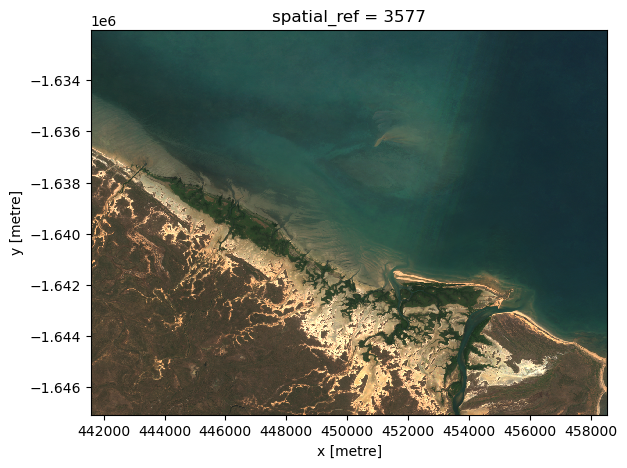

In [85]:
ds[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().median(dim="time").plot.imshow(vmin=0, vmax=2500, size=5)

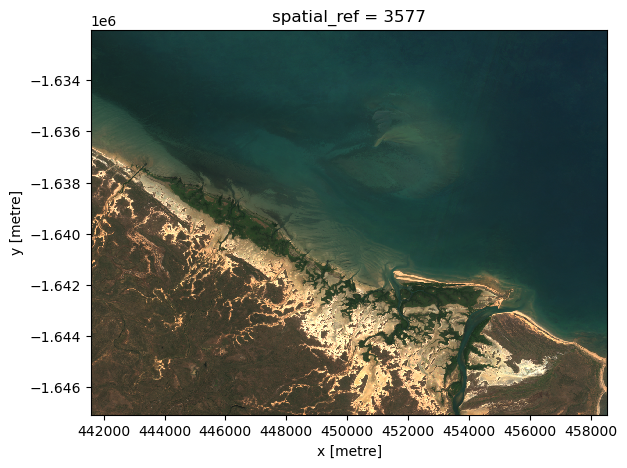

In [86]:
ds[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().where(glint_array > 30).median(dim="time").plot.imshow(vmin=0, vmax=2500, size=5)

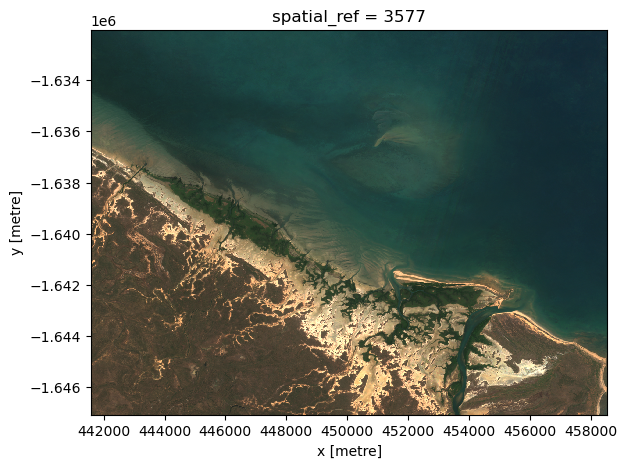

In [88]:
ndwi = (ds.nbart_green - ds.nbart_nir_1) / (ds.nbart_green + ds.nbart_nir_1)
glint = glint_array < 30
glint_mask = ~(glint & (ndwi > 0))
ds[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().where(glint_mask).median(dim="time").plot.imshow(vmin=0, vmax=2500, size=5)

In [90]:
import odc.geo.xr
ds[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().where(glint_mask).median(dim="time").odc.write_cog("test_median.tif", overwrite=True)

PosixPath('test_median.tif')

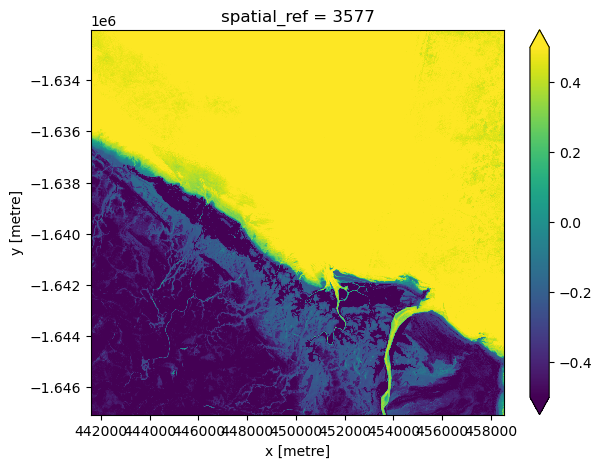

In [91]:
ndwi.where(~glint).median(dim="time").plot.imshow(vmin=-0.5, vmax=0.5, size=5)

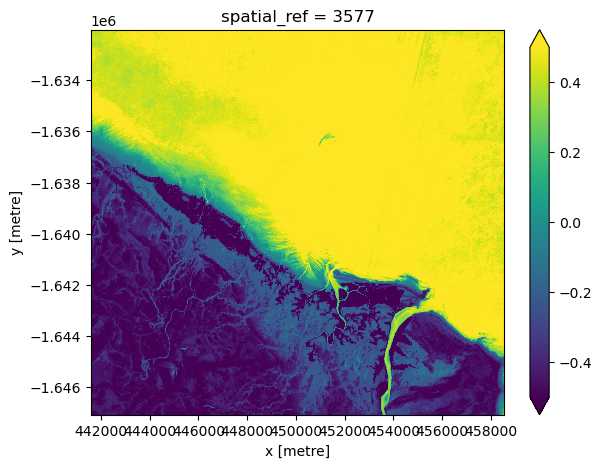

In [92]:
ndwi.where(glint_mask).median(dim="time").plot.imshow(vmin=-0.5, vmax=0.5, size=5)